# Spatial Modelling

In [1]:
%load_ext lab_black

In [2]:
import gpjax
import gpjax.core as gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

## Introduction

We'll be working through a simple spatial modelling workflow in this notebook. In reality, the process is often more complicated than what is shown here as exogenous data is often used to better understand the latent process. Further, complex kernel structures are frequently used as the underlying process is often complex and non-stationary. Finally, spatial data can often be challenging to work with due to incosistent sampling schemes and anomalous data measurements. That being said, this notebook should serve as a good introduction to using GPJax with spatial inputs.

### Datasets

We'll be modelling NO$_2$ levels in London using the [Breathe London](https://www.breathelondon.org/) sensor network. The dataset is spatiotemporal with many missing values through time due to sensors being turned on and off intermittently. For this reason, we'll be working on a spatial slice that corresponds to 9am on the 15th February 2019. The data has been preprocessed in the [spatial_preprocessing.py](https://github.com/thomaspinder/GPJax/blob/master/docs/nbs/spatial_preprocessing.py) file, but is also available through the below path.

In [3]:
aq = gpd.read_file("datasets/aq/aq.shp")
aq.head()

,latitude,longitude,no2_ugm3,geometry
0,51.555485,-0.152338,63.00,POINT (-0.15234 51.55548)
1,51.440399,-0.186775,115.14,POINT (-0.18677 51.44040)
2,51.468625,-0.359770,88.06,POINT (-0.35977 51.46863)
3,51.560877,-0.195749,107.31,POINT (-0.19575 51.56088)
4,51.529308,-0.048721,119.46,POINT (-0.04872 51.52931)


To enhance the plotting of this model, we'll also load in a shapefile that described the ward boundaries in London. This file needs no preprocessing and is, again, availabe through the below path. For those wishing to obtain the source file, it can be found [here](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london).

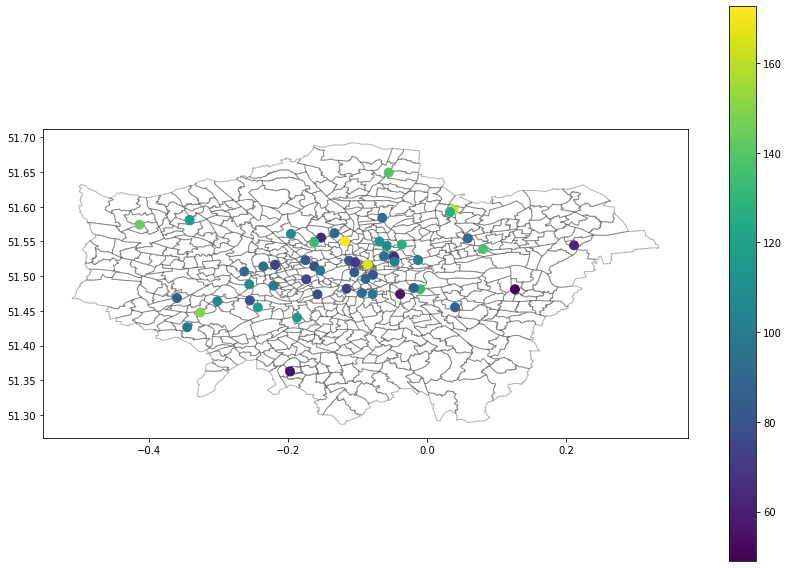

In [4]:
london_boundaries = gpd.read_file("datasets/spatial/London_Ward.shp")

ax = london_boundaries.to_crs(epsg=4326).plot(
    color="white", edgecolor="black", figsize=(12, 8), alpha=0.3
)
cax = aq.plot(ax=ax, column="no2_ugm3", markersize=80, legend=True)
plt.tight_layout()

### Data preprocessing

We can now extract our training inputs and outputs. As the data is spatial, out inputs $X \in \mathbb{R}^2$ with one dimension governing the longitudinal values, and the other dimension for latitudinal values. Our outputs here are still univariate.

To make the data amenable to modelling in GPJax, we'll store it as a Jax array.

In [5]:
Xraw = jnp.array(aq[["longitude", "latitude"]].values)
yraw = jnp.array(aq[["no2_ugm3"]].values)

As can be seen from the above dataframe, the data's values are currently on wildly different scales. To impose uniformity on the data, we'll first standardise the data such that all values are distributed according to a unit-normal. We can use the `standardise` utility function in GPJax to achieve this.

In [6]:
X, Xmean, Xstd = gpjax.utils.standardise(Xraw)
y, ymean, ystd = gpjax.utils.standardise(yraw)
training = gpx.Dataset(X=X, y=y)

To convince ourself that this has had the desired effect on our data, we can plot our original dataset and our newly transformed dataset to compare their respective distributions.

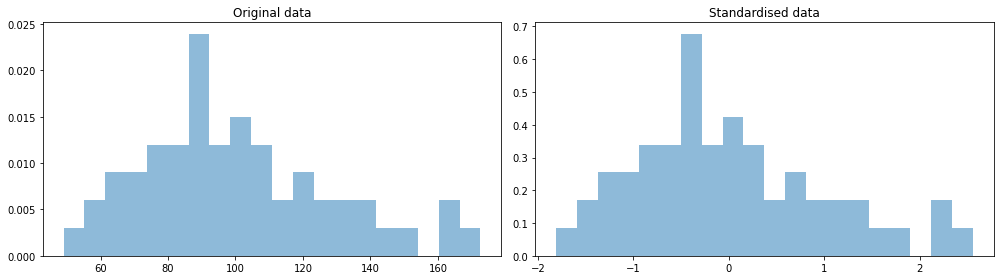

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].hist(yraw.squeeze(), alpha=0.5, bins=20, density=True)
ax[1].hist(y.squeeze(), alpha=0.5, bins=20, density=True)
ax[0].set_title("Original data")
ax[1].set_title("Standardised data")
plt.tight_layout()

## ARD Kernels

We'll express each of the spatial dimensions independently using an automatic relevance determination (ARD) kernel structure. To see this, if we consider our regular RBF kernel, then all of the inputs are scaled by a single lengthscale parameter. However, imposing an ARD structure on our RBF kernel means that each inputs is scaled by its own lengthscale parameter. Mathematically, for a 2-dimensional spatial input $x \in \mathbb{R}^2$ this can be written as

$$k(x, x') = \sigma^2 \exp\bigg(-\frac{1}{2} \sum_{i=1}^2\frac{\lVert x-x'\rVert_2^2}{-\ell_i^2}\bigg)$$

To do this in GPJax, we simply need to express the input dimensionality when defining the kernel. Note that it would have been equally valid syntactically here to enter 1 as the number of dimensions, though the resultant kernel would hold a single lenghtscale parameter for all dimensions.

In [8]:
kernel = gpx.RBF(ndims=X.shape[1])

We can verify that the kernel has an ARD structure using the `ard` property.

In [9]:
kernel.ard

True

## Building our model

We can now use our ARD kernel to build a Gaussian process emulator in the same way that we have in the [regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html). 

In [10]:
posterior = gpx.Prior(kernel=kernel) * gpx.Gaussian()

### Parameters

When we initialise the model's parameters, we can see that our kernel's lengthscale parameter now consists of two values, rather than the original single value.

In [11]:
params = gpx.initialise(posterior)
configs = gpx.get_defaults()
constrainer, unconstrainer = gpx.build_all_transforms(params.keys(), configs)
params = unconstrainer(params)
params

{'lengthscale': DeviceArray([0.54132485, 0.54132485], dtype=float64),
 'obs_noise': DeviceArray([0.54132485], dtype=float64),
 'variance': DeviceArray([0.54132485], dtype=float64)}

## Optimisation

We can now optimise our GP's marginal log-likelihood with respect to the hyperparameters using the Adam optimiser.

In [12]:
from jax.experimental import optimizers


mll = jax.jit(gpx.marginal_ll(posterior, transform=constrainer, negative=True))

opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
opt_state = opt_init(params)


def step(i, opt_state):
    p = get_params(opt_state)
    v, g = jax.value_and_grad(mll)(p, training)
    return opt_update(i, g, opt_state), v


nits = 200
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

## Understanding our model

### Parameter interpretation

In a real-world context such as this, there is significant information to be learned from querying the model's parameters. In this instance, the legnthscale parameter is particularly informative as it describes how the process' correlation structure changes in the latitude and longitude direction.

In [13]:
final_params = constrainer(get_params(opt_state))
final_params

{'lengthscale': DeviceArray([1.13613352, 1.86880955], dtype=float64),
 'obs_noise': DeviceArray([0.85069114], dtype=float64),
 'variance': DeviceArray([0.39824761], dtype=float64)}

The fact that the lengthscale parameter's second value is larger than the first tells us that, based on our GP emulator, the underlying process' correlation decays more slowly latitudinally compared to longitudinally. 

### Prediction

We don't have a train-test data partition here as we do with many machine learning tasks. Instead, we fit our GP to the entire dataset and will instead query it across the entire spatial domain to try an infer how NO$_2$ levels change spatially.

To do this we'll first simulate a grid using the `meshgrid` function.

In [14]:
xx = jnp.linspace(aq.longitude.min() - 0.05, aq.longitude.max() + 0.05, num=50)
yy = jnp.linspace(aq.latitude.min() - 0.05, aq.latitude.max() + 0.05, num=50)
coords = jnp.hstack([i.ravel().reshape(-1, 1) for i in jnp.meshgrid(xx, yy)])

We'll now standardise this grid according to the mean and standard deviation that we computed for our original air quality data.

In [15]:
query_coords = gpjax.utils.standardise(coords, Xmean, Xstd)

With a coordinate grid in place, we can now query our GP at each coordinate location using the regular `mean` and `variance` functions.

In [16]:
predictive_mean = gpx.mean(posterior, final_params, training)(query_coords)
predictive_variance = jnp.diag(
    gpx.variance(posterior, final_params, training)(query_coords)
).reshape(-1, 1)

In [17]:
import pandas as pd

mu = gpjax.utils.unstandardise(predictive_mean, ymean, ystd)
sigma = gpjax.utils.unstandardise(predictive_variance, ymean, ystd)

preds = pd.DataFrame(
    jnp.hstack((coords, mu, sigma)),
    columns=["longitude", "latitude", "mean", "variance"],
)
preds.head()

,longitude,latitude,mean,variance
0,-0.463580,51.312842,100.730104,111.101516
1,-0.448776,51.312842,100.592327,110.999451
2,-0.433972,51.312842,100.396459,110.886620
3,-0.419168,51.312842,100.135231,110.763338
4,-0.404364,51.312842,99.802793,110.629905


### Visualising the learned suface

We can now visualise our latent process and overlay our earlier defined station measurements and London geometry. We can see from this plot that NO$_2$ levels are greater in North East London and less in South East London. 

/home/pindert2/Documents/phd_docs/GPJax/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


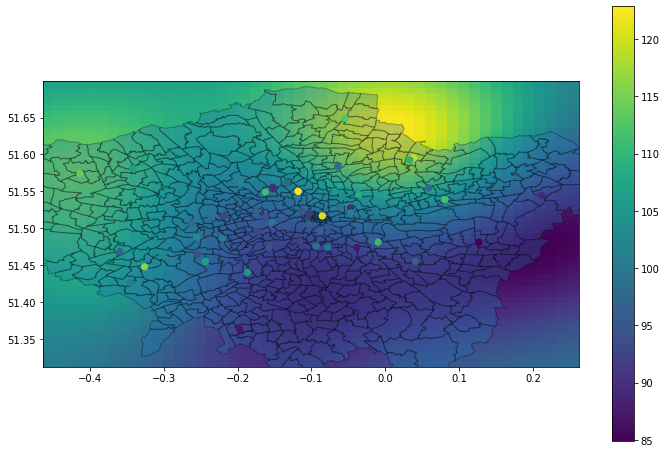

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.pcolormesh(
    xx, yy, preds.pivot(index="latitude", columns="longitude", values="mean")
)
london_boundaries.to_crs(epsg=4326).plot(
    color=None, edgecolor="black", figsize=(12, 8), alpha=0.3, ax=ax
)
aq.plot(
    ax=ax,
    column="no2_ugm3",
    markersize=40,
)

plt.xlim(preds.longitude.min(), preds.longitude.max())
plt.ylim(preds.latitude.min(), preds.latitude.max())
fig.colorbar(cax, ax=ax)

To properly understand the behaviour of NO$_2$ in London we'd need to build a more sophisticated model using a larger dataset and by incorporating covariate information. However, hopefully this serves as a starting point for people wishing to use GPJax for applicational purposes, and also for those wishing to employ ARD kernel structures.

## System configuration

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"

jax       0.2.10
pandas    1.1.5
geopandas 0.9.0
gpjax     0.3.6
Thomas Pinder 
last updated: Fri May 07 2021 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
